In [1]:
%pip install timm
%pip install timm mplcyberpunk
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 17.7 MB/s  0:00:00

   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   -------------------------- ------------- 2/3 [ipywidgets]
   ---------------------------------------- 3/3 [ipywidgets]

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import os, json, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy

try:
    from tqdm.auto import tqdm
except Exception:
    from tqdm import tqdm  

import timm
from PIL import Image
import mplcyberpunk
plt.style.use("cyberpunk")

In [3]:
print("torch:", torch.__version__)
print("timm :", timm.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

torch: 2.5.1+cu121
timm : 1.0.19
device: cuda
GPU: NVIDIA GeForce GTX 1650 Ti


In [4]:
REPO_ROOT = Path.cwd().parents[1] if (Path.cwd().name == "classification" and Path.cwd().parent.name == "notebooks") else Path.cwd()
SPLIT_DIR = REPO_ROOT / "data" / "processed" / "classification" / "blood_cell_images_for_cancer_detection_processed" / "splits" / "fold0"
assert SPLIT_DIR.exists(), f"Missing splits at: {SPLIT_DIR}"

with open(SPLIT_DIR / "label_map.json") as f:
    label_map = {int(k): v for k, v in json.load(f).items()}
class_names = [label_map[i] for i in sorted(label_map)]
num_classes = len(class_names)
print("classes:", class_names)

class CSVDataset(Dataset):
    def __init__(self, csv_path, transform=None, repo_root=REPO_ROOT):
        df = pd.read_csv(csv_path)
        self.paths = [repo_root / p for p in df["path"].tolist()]
        self.labels = df["label"].astype(int).tolist()
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, self.labels[idx]


classes: ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']


In [6]:
train_ds = CSVDataset(SPLIT_DIR / "train.csv", transform=train_tfms)
val_ds   = CSVDataset(SPLIT_DIR / "val.csv",   transform=val_tfms)
test_ds  = CSVDataset(SPLIT_DIR / "test.csv",  transform=val_tfms)

batch_size   = 32        
num_workers  = 0         # safe on Windows
pin          = torch.cuda.is_available()

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin)

len(train_ds), len(val_ds), len(test_ds)


(3500, 750, 750)

In [ ]:
vit_name = "vit_tiny_patch16_224"   
model = timm.create_model(vit_name, pretrained=True, num_classes=num_classes)
model.to(device)
print("Model:", vit_name)


Model: vit_tiny_patch16_224


In [8]:
criterion = nn.CrossEntropyLoss()                 
base_lr   = 3e-4 * (batch_size / 32)         
optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=0.05)

epochs        = 20
scheduler     = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


In [9]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler(enabled=torch.cuda.is_available())

def run_epoch(loader, train=True):
    model.train(train)
    loss_sum = 0.0
    logits_all, targets_all = [], []
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                logits = model(x)
                loss   = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):
                logits = model(x); loss = criterion(logits, y)

        loss_sum += loss.item() * x.size(0)
        logits_all.append(logits.detach().float().cpu())
        targets_all.append(y.detach().long().cpu())

    loss_epoch = loss_sum / len(loader.dataset)
    logits_all = torch.cat(logits_all); targets_all = torch.cat(targets_all)
    auroc = MulticlassAUROC(num_classes=num_classes, average="macro")(logits_all.softmax(1), targets_all).item()
    acc   = MulticlassAccuracy(num_classes=num_classes, average="macro")(logits_all.argmax(1), targets_all).item()
    return loss_epoch, acc, auroc


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29448\3653217812.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())


In [10]:
def fit(epochs=20, ckpt_name="cls_bloodcells_vit_tiny.pt"):
    CKPT_DIR = REPO_ROOT / "checkpoints" / "classification"
    MET_DIR  = REPO_ROOT / "results" / "metrics"
    CKPT_DIR.mkdir(parents=True, exist_ok=True); MET_DIR.mkdir(parents=True, exist_ok=True)

    best = -1e9; hist = []
    for ep in range(1, epochs+1):
        tr_loss, tr_acc, tr_auc = run_epoch(train_loader, True)
        va_loss, va_acc, va_auc = run_epoch(val_loader,   False)
        scheduler.step()
        hist.append({"epoch":ep,"train_loss":tr_loss,"train_acc":tr_acc,"train_auroc":tr_auc,
                     "val_loss":va_loss,"val_acc":va_acc,"val_auroc":va_auc,"lr":scheduler.get_last_lr()[0]})
        print(f"[{ep:03d}] train: loss {tr_loss:.4f} acc {tr_acc:.3f} auroc {tr_auc:.3f} | "
              f"val: loss {va_loss:.4f} acc {va_acc:.3f} auroc {va_auc:.3f}")

        if va_auc > best:
            best = va_auc
            torch.save({"state_dict": model.state_dict(),
                        "class_names": class_names,
                        "num_classes": num_classes,
                        "model_name": vit_name},
                       CKPT_DIR / ckpt_name)

    with open(MET_DIR / "bloodcells_vit_tiny_history.json", "w") as f:
        json.dump(hist, f, indent=2)
    print("Best val AUROC:", best)
    return hist

In [11]:
history = fit(epochs=epochs, ckpt_name=f"cls_bloodcells_{vit_name}.pt")

  0%|          | 0/110 [00:00<?, ?it/s]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29448\3653217812.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


  0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29448\3653217812.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=torch.cuda.is_available()):


[001] train: loss 0.4086 acc 0.851 auroc 0.978 | val: loss 0.0453 acc 0.987 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[002] train: loss 0.0645 acc 0.979 auroc 0.999 | val: loss 0.0422 acc 0.988 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[003] train: loss 0.0695 acc 0.976 auroc 0.999 | val: loss 0.0383 acc 0.988 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[004] train: loss 0.0459 acc 0.985 auroc 0.999 | val: loss 0.0211 acc 0.995 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[005] train: loss 0.0449 acc 0.984 auroc 1.000 | val: loss 0.0765 acc 0.976 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[006] train: loss 0.0346 acc 0.990 auroc 1.000 | val: loss 0.0138 acc 0.996 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[007] train: loss 0.0151 acc 0.996 auroc 1.000 | val: loss 0.0219 acc 0.995 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[008] train: loss 0.0193 acc 0.994 auroc 1.000 | val: loss 0.0128 acc 0.993 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[009] train: loss 0.0154 acc 0.995 auroc 1.000 | val: loss 0.0168 acc 0.995 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[010] train: loss 0.0034 acc 0.999 auroc 1.000 | val: loss 0.0054 acc 0.997 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[011] train: loss 0.0066 acc 0.997 auroc 1.000 | val: loss 0.0038 acc 1.000 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[012] train: loss 0.0052 acc 0.998 auroc 1.000 | val: loss 0.0444 acc 0.988 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[013] train: loss 0.0111 acc 0.997 auroc 1.000 | val: loss 0.0134 acc 0.992 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[014] train: loss 0.0037 acc 0.999 auroc 1.000 | val: loss 0.0165 acc 0.995 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[015] train: loss 0.0079 acc 0.998 auroc 1.000 | val: loss 0.0083 acc 0.996 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[016] train: loss 0.0012 acc 1.000 auroc 1.000 | val: loss 0.0073 acc 0.996 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[017] train: loss 0.0006 acc 1.000 auroc 1.000 | val: loss 0.0075 acc 0.997 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[018] train: loss 0.0004 acc 1.000 auroc 1.000 | val: loss 0.0072 acc 0.997 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[019] train: loss 0.0005 acc 1.000 auroc 1.000 | val: loss 0.0074 acc 0.997 auroc 1.000


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[020] train: loss 0.0004 acc 1.000 auroc 1.000 | val: loss 0.0073 acc 0.997 auroc 1.000
Best val AUROC: 1.0


In [12]:
def plot_confusion_matrix_cyberpunk(cm, class_names, title, save_path):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, cmap="magma")
    fig.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(len(class_names)), labels=class_names, rotation=30, ha="right")
    ax.set_yticks(np.arange(len(class_names)), labels=class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    # annotate
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    mplcyberpunk.make_lines_glow(ax=ax)
    plt.tight_layout()
    fig.savefig(save_path, dpi=150)
    plt.show()
    print("Saved →", save_path)

In [13]:
CKPT = REPO_ROOT / "checkpoints" / "classification" / f"cls_bloodcells_{vit_name}.pt"
state = torch.load(CKPT, map_location=device)
model.load_state_dict(state["state_dict"]); model.eval()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29448\1500760688.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(CKPT, map_location=device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


Test Accuracy (macro): 0.9907
Test Macro AUROC    : 0.9985


,precision,recall,f1,support
basophil,1.000000,0.966667,0.983051,150
erythroblast,1.000000,0.993333,0.996656,150
monocyte,0.961538,1.000000,0.980392,150
myeloblast,0.993377,1.000000,0.996678,150
seg_neutrophil,1.000000,0.993333,0.996656,150


Saved → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures\vit_confusion_matrix_counts.png


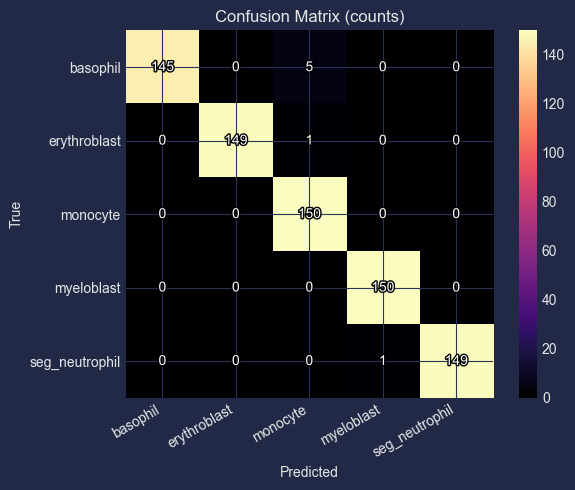

Saved → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures\vit_confusion_matrix_norm.png


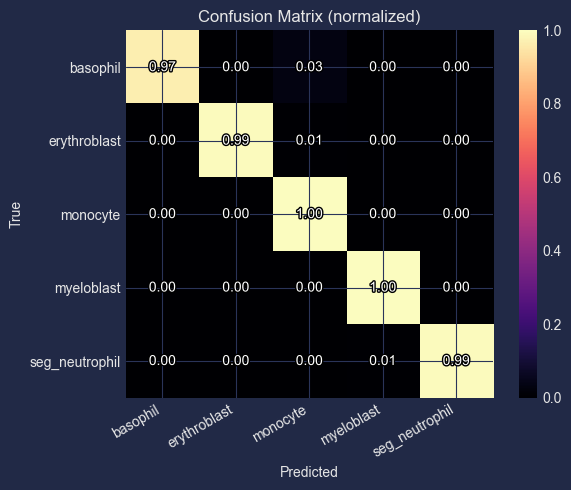

In [17]:
import torch, numpy as np, pandas as pd
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt, matplotlib.patheffects as pe
import mplcyberpunk
plt.style.use("cyberpunk")

pin = torch.cuda.is_available()
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=pin)

model.eval()
logits_list, targets_list = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        logits_list.append(model(x).cpu())
        targets_list.append(torch.as_tensor(y))

logits   = torch.cat(logits_list)           
probs_t  = torch.softmax(logits, dim=1)     
targets  = torch.cat(targets_list).long()   
preds_t  = probs_t.argmax(dim=1)            
preds    = preds_t.numpy()
targets_np = targets.numpy()


auroc = MulticlassAUROC(num_classes=num_classes, average="macro")(probs_t, targets).item()
acc   = MulticlassAccuracy(num_classes=num_classes, average="macro")(preds_t, targets).item()
prec, rec, f1, sup = precision_recall_fscore_support(targets_np, preds, labels=range(num_classes), zero_division=0)

print(f"Test Accuracy (macro): {acc:.4f}")
print(f"Test Macro AUROC    : {auroc:.4f}")

per_class_df = pd.DataFrame(
    {"precision": prec, "recall": rec, "f1": f1, "support": sup},
    index=class_names
)
display(per_class_df)


cm = confusion_matrix(targets_np, preds)

def plot_confusion_matrix_cyberpunk(cm, class_names, title, save_path=None, normalize=False):
    cm_disp = cm.astype(float)
    if normalize:
        row_sums = cm_disp.sum(axis=1, keepdims=True).clip(min=1)
        cm_disp = cm_disp / row_sums

    fig, ax = plt.subplots(figsize=(7,5))
    im = ax.imshow(cm_disp, cmap="magma")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_xticks(np.arange(len(class_names)), labels=class_names, rotation=30, ha="right")
    ax.set_yticks(np.arange(len(class_names)), labels=class_names)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)

   
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            txt = f"{cm_disp[i, j]:.2f}" if normalize else f"{cm[i, j]}"
            ax.text(j, i, txt, ha="center", va="center", color="white", fontsize=10,
                    path_effects=[pe.withStroke(linewidth=2, foreground="black")])

    mplcyberpunk.make_lines_glow(ax=ax)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=150)
        print("Saved →", save_path)
    plt.show()

FIG_DIR = (REPO_ROOT / "results" / "figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

# Counts
plot_confusion_matrix_cyberpunk(
    cm, class_names,
    title="Confusion Matrix (counts)",
    save_path=FIG_DIR / "vit_confusion_matrix_counts.png",
    normalize=False
)

# Normalized
plot_confusion_matrix_cyberpunk(
    cm, class_names,
    title="Confusion Matrix (normalized)",
    save_path=FIG_DIR / "vit_confusion_matrix_norm.png",
    normalize=True
)


In [19]:
def _unique_legend(ax):
    """Remove duplicate legend entries (caused by cyberpunk glow)."""
    handles, labels = ax.get_legend_handles_labels()
    seen, new_h, new_l = set(), [], []
    for h, l in zip(handles, labels):
        if l not in seen and l != "_nolegend_":
            new_h.append(h); new_l.append(l); seen.add(l)
    ax.legend(new_h, new_l, loc="best", frameon=True)

def plot_training_curves_cyberpunk_fixed(hist_json_path, title_prefix):
    hist = json.loads(Path(hist_json_path).read_text())
    epochs  = [h["epoch"] for h in hist]
    tr_loss = [h["train_loss"] for h in hist]; va_loss = [h["val_loss"] for h in hist]
    tr_auc  = [h["train_auroc"] for h in hist]; va_auc  = [h["val_auroc"] for h in hist]

    # Loss
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(epochs, tr_loss, label="train loss", linewidth=2)
    ax.plot(epochs, va_loss, label="val loss", linewidth=2)
    mplcyberpunk.make_lines_glow(ax=ax)
    ax.set_title(f"{title_prefix} — Loss"); ax.set_xlabel("epoch"); ax.set_ylabel("loss")
    ax.margins(x=0)
    _unique_legend(ax)
    plt.tight_layout(); plt.show()

    # AUROC
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(epochs, tr_auc, label="train AUROC", linewidth=2)
    ax.plot(epochs, va_auc, label="val AUROC", linewidth=2)
    mplcyberpunk.make_lines_glow(ax=ax)
    ax.set_title(f"{title_prefix} — Macro AUROC"); ax.set_xlabel("epoch"); ax.set_ylabel("AUROC")
    ax.margins(x=0)
    _unique_legend(ax)
    plt.tight_layout(); plt.show()


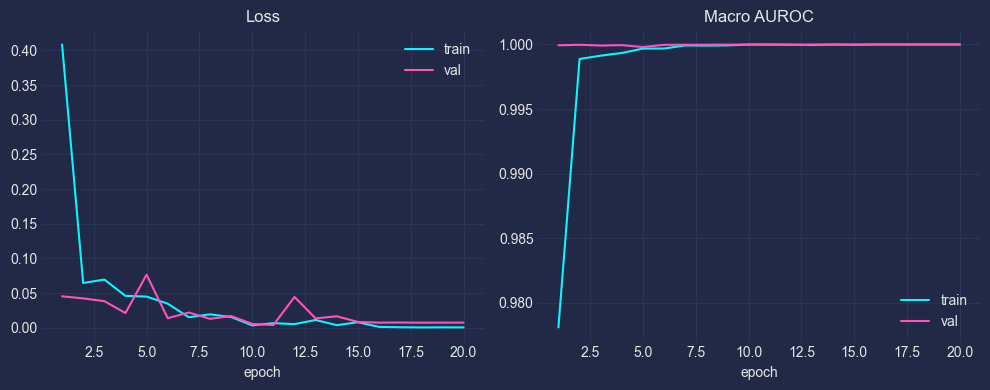

In [21]:
import json, matplotlib.pyplot as plt, numpy as np
from pathlib import Path

hist_path = REPO_ROOT / "results" / "metrics" / "bloodcells_vit_tiny_history.json"
hist = json.loads(Path(hist_path).read_text())
epochs = [h["epoch"] for h in hist]
tr_loss = [h["train_loss"] for h in hist]; va_loss = [h["val_loss"] for h in hist]
tr_auc  = [h["train_auroc"] for h in hist]; va_auc  = [h["val_auroc"] for h in hist]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(epochs, tr_loss, label="train"); plt.plot(epochs, va_loss, label="val")
plt.title("Loss"); plt.xlabel("epoch"); plt.legend()
plt.subplot(1,2,2); plt.plot(epochs, tr_auc, label="train"); plt.plot(epochs, va_auc, label="val")
plt.title("Macro AUROC"); plt.xlabel("epoch"); plt.legend()
plt.tight_layout(); plt.show()

In [22]:
# --- Cyberpunk model diagram (ViT) ---
import math
from pathlib import Path
import matplotlib.pyplot as plt

# deps
try:
    import networkx as nx
except ModuleNotFoundError:
    import sys, subprocess; subprocess.check_call([sys.executable, "-m", "pip", "install", "networkx"]); import networkx as nx
try:
    import mplcyberpunk
except ModuleNotFoundError:
    import sys, subprocess; subprocess.check_call([sys.executable, "-m", "pip", "install", "mplcyberpunk"]); import mplcyberpunk

import torch
from torch import nn

# repo root
REPO_ROOT = Path.cwd().parents[1] if (Path.cwd().name == "classification" and Path.cwd().parent.name == "notebooks") else Path.cwd()

def count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

def vit_feature_shapes(model: nn.Module, input_size=(1,3,224,224), device="cpu"):
    """Collect output shapes of ViT stages via forward hooks."""
    shapes = {}
    handles = []

    def reg(name, module):
        if module is None: return
        def hook(_m, _in, out):
            if isinstance(out, (tuple, list)): out = out[0]
            try: shapes[name] = tuple(out.shape)
            except Exception: shapes[name] = None
        handles.append(module.register_forward_hook(hook))

    reg("patch_embed", getattr(model, "patch_embed", None))
    # all transformer blocks
    for i, blk in enumerate(getattr(model, "blocks", [])):
        reg(f"block{i}", blk)
    reg("norm", getattr(model, "norm", None))
    reg("head", getattr(model, "head", None))

    x = torch.randn(*input_size, device=device)
    model.eval()
    with torch.no_grad():
        _ = model(x)

    for h in handles: h.remove()
    return shapes

def plot_vit_arch_cyberpunk(model: nn.Module, name="vit_tiny_patch16_224",
                            input_size=(1,3,224,224), device="cpu"):
    # 1) get shapes
    shapes = vit_feature_shapes(model.to(device), input_size=input_size, device=device)

    # 2) parameter counts per stage
    params = {"patch_embed": count_params(getattr(model, "patch_embed", nn.Identity()))}
    for i, blk in enumerate(getattr(model, "blocks", [])):
        params[f"block{i}"] = count_params(blk)
    params["norm"] = count_params(getattr(model, "norm", nn.Identity()))
    params["head"] = count_params(getattr(model, "head", nn.Identity()))

    # 3) build graph
    stages = ["Input", "patch_embed"] + [f"block{i}" for i in range(len(getattr(model, "blocks", [])))] + ["norm", "head", "Output"]
    G = nx.DiGraph()
    for s in stages: G.add_node(s)
    for a, b in zip(stages[:-1], stages[1:]): G.add_edge(a, b)

    def shp_label(key):
        shp = shapes.get(key)
        if shp is None: return ""
        # ViT usually emits (B, N, C) tokens until the head (B, num_classes)
        if len(shp) == 3:
            _, N, C = shp
            return f"{N}×{C} tokens"
        if len(shp) == 2:
            _, F = shp
            return f"{F}"
        return "?"

    labels = {}
    for s in stages:
        if s in ("Input", "Output"):
            labels[s] = s
        else:
            p = params.get(s, 0)
            ptxt = f"{p/1e6:.2f}M" if p >= 1e6 else (f"{p/1e3:.1f}K" if p > 0 else "0")
            labels[s] = f"{s}\n{shp_label(s)}\n{ptxt}"

    # layout + sizes
    pos = {s: (i, 0) for i, s in enumerate(stages)}
    sizes = []
    for s in stages:
        p = params.get(s, 0)
        sizes.append(1200 if p == 0 else int(1200 + 2800 * math.log10(p + 10)))

    # 4) draw
    plt.style.use("cyberpunk")
    fig_w = min(2 + 1.3*len(stages), 22)
    fig, ax = plt.subplots(figsize=(fig_w, 4.2))
    nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowstyle='-|>', arrowsize=20, width=2)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_shape='s', node_size=sizes)
    nx.draw_networkx_labels(G, pos, ax=ax, labels=labels, font_size=8)
    ax.set_title(f"{name} — Transformer Stage Diagram (output shapes & params)")
    ax.axis("off")
    mplcyberpunk.make_lines_glow(ax=ax)

    # save
    FIG_DIR = REPO_ROOT / "results" / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)
    out_path = FIG_DIR / f"{name}_arch_cyberpunk.png"
    plt.tight_layout(); plt.savefig(out_path, dpi=160); plt.show()
    print("Saved:", out_path)

    # textual summary
    total_params = count_params(model)
    print(f"Blocks: {len(getattr(model, 'blocks', []))} | Trainable params: {total_params/1e6:.2f}M")
    shp_pe = shapes.get("patch_embed")
    if shp_pe and len(shp_pe) == 3:
        _, N, C = shp_pe
        print(f"PatchEmbed → {N} tokens, embed dim {C} (class token added before blocks).")


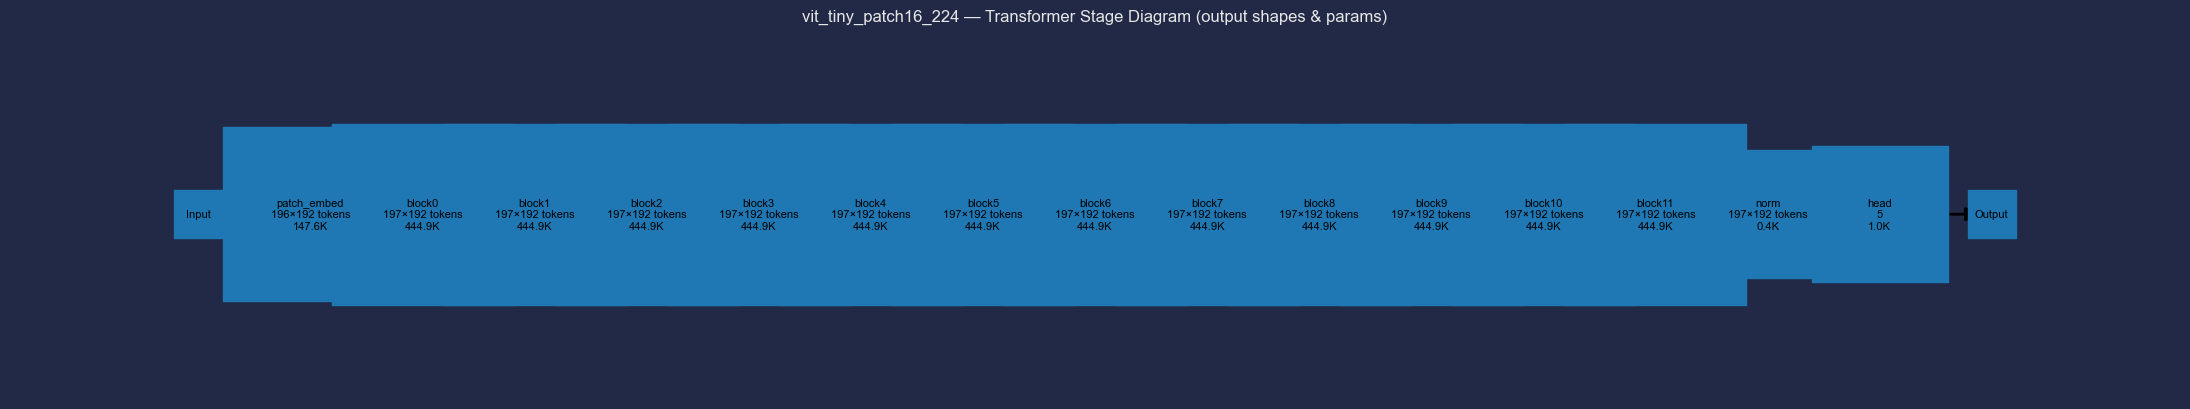

Saved: c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\results\figures\vit_tiny_patch16_224_arch_cyberpunk.png
Blocks: 12 | Trainable params: 5.53M
PatchEmbed → 196 tokens, embed dim 192 (class token added before blocks).


In [23]:
plot_vit_arch_cyberpunk(
    model,
    name=vit_name,                 # appears in the title & filename
    input_size=(1, 3, 224, 224),   # change if you used a different img size
    device=device
)

In [1]:
from pathlib import Path
import json, torch, timm

# 1) paths & names
REPO_ROOT = Path.cwd().parents[1] if (Path.cwd().name=="classification" and Path.cwd().parent.name=="notebooks") else Path.cwd()
TS_DIR    = REPO_ROOT / "exports" / "torchscript"
ONNX_DIR  = REPO_ROOT / "exports" / "onnx"
TS_DIR.mkdir(parents=True, exist_ok=True)
ONNX_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
vit_name  = "vit_tiny_patch16_224"                 
ckpt_name = f"cls_bloodcells_{vit_name}.pt"        
ckpt_path = REPO_ROOT / "checkpoints" / "classification" / ckpt_name
assert ckpt_path.exists(), f"Checkpoint not found: {ckpt_path}"

In [3]:
device = torch.device("cpu")  
state  = torch.load(ckpt_path, map_location=device)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11620\2905079092.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state  = torch.load(ckpt_path, map_location=device)


In [4]:
num_classes = state["num_classes"]
class_names = state.get("class_names", [str(i) for i in range(num_classes)])
model = timm.create_model(vit_name, pretrained=False, num_classes=num_classes)
model.load_state_dict(state["state_dict"])
model.eval().to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


In [5]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
img_size = (3, 224, 224)

dummy = torch.randn(1, *img_size, device=device)
ts_path = TS_DIR / ckpt_name.replace(".pt", ".pt")
traced = torch.jit.trace(model, dummy, strict=False)
torch.jit.save(traced, ts_path)
print("TorchScript saved →", ts_path)

c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\.venv\Lib\site-packages\torch\__init__.py:2040: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message


TorchScript saved → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\exports\torchscript\cls_bloodcells_vit_tiny_patch16_224.pt


In [6]:
try:
    import onnx  
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])
    import onnx  

onnx_path = ONNX_DIR / ckpt_name.replace(".pt", ".onnx")
torch.onnx.export(
    model, dummy, onnx_path.as_posix(),
    input_names=["input"], output_names=["logits"],
    opset_version=17, do_constant_folding=True,
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}}
)

import onnx
onnx.checker.check_model(onnx.load(onnx_path.as_posix()))
print("ONNX saved →", onnx_path)


meta = {
    "model_name": vit_name,
    "checkpoint": ckpt_path.name,
    "image_size": img_size,
    "mean": mean, "std": std,
    "num_classes": num_classes,
    "class_names": class_names,
}

ONNX saved → c:\Users\Lenovo\Desktop\Exploration-of-ViT-and-CNN-for-Medical-Image-Processing\exports\onnx\cls_bloodcells_vit_tiny_patch16_224.onnx
